# Question 4: Image retrieval with Metric trees

## Dataset preparation

In order to perform image retrieval, we first load our dataset: CIFAR-10.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from typing import Tuple
from tqdm import tqdm
import cv2

In [2]:
# Loading the dataset (1st batch of CIFAR-10)
with open("cifar-10/data_batch_1", "rb") as file:
    cifar = pickle.load(file, encoding="bytes")
text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
cifar_labels = cifar[b'labels']

# Converting the images to the appropriate format
cifar_images = np.moveaxis(cifar[b'data'].reshape(10000, 3, 32, 32)/255., 1, -1)
cifar_images_gray = cifar_images.mean(axis=-1)

# Selecting the elements that will be used for building the metric tree
# For time concerns, we consider only 30 images in our tree
data_color = cifar_images[:30]
data_gray = cifar_images_gray[:30]
data_labels = list(map(lambda i: text_labels[i], cifar_labels[:30]))

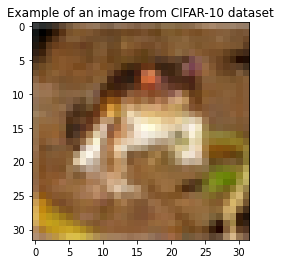

In [3]:
plt.title("Example of an image from CIFAR-10 dataset")
plt.imshow(cifar_images[0])

Text(0.5, 0.98, 'Images used to build the Metric tree')

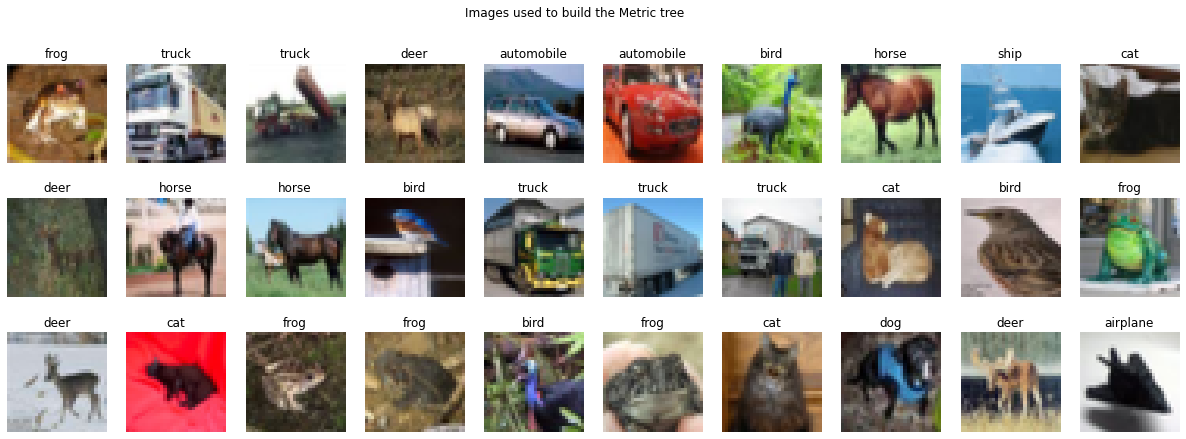

In [4]:
fig, ax = plt.subplots(3,10, figsize=(21,7))
for i, image in enumerate(data_color):
    ax[i//10, i%10].imshow(image, cmap="gray")
    ax[i//10, i%10].title.set_text(data_labels[i])
    ax[i//10, i%10].axis("off")
fig.suptitle("Images used to build the Metric tree")

## Earth Mover's Distance

The metric used for image retrieval here is the Earth Mover's Distance. We use the implementation of opencv and therefore we wrote some utils functions to ease the implementation of the Metric tree.

In [5]:
# Earth Mover's Distance implementation in cv2 expects a particular format (called signature) for the input which is:
# the value of the pixel in rows with their position [[value, position_y, position_x, channel]]

def img_to_sig(arr):
    """Convert a 2D array to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
    channel = 1 if len(arr.shape) == 2 else arr.shape[2]
    sig = np.empty((arr.size, 4), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for c in range(channel):
                if channel == 1:
                    sig[count] = np.array([arr[i,j], i, j, c])
                else:
                    sig[count] = np.array([arr[i,j,c], i, j, c])
                count += 1
    return sig

def EMD(point1, point2):
    sig1 = img_to_sig(point1)
    sig2 = img_to_sig(point2)
    return cv2.EMD(sig1, sig2, cv2.DIST_L2)[0]

In [6]:
%%time
# Example of computation of Earth Mover's Distance via cv2.EMD
dist = EMD(data_gray[0], data_gray[1])
print(dist)

0.492384135723114
Wall time: 3.95 s


In [7]:
# Computing all the distances between the root point and the remaining points is required during the building of the tree

def all_distances(root, remaining_points):
    root_sig = img_to_sig(root)
    distances = []
    for point in remaining_points:
        point_sig = img_to_sig(point)
        distances.append(cv2.EMD(root_sig, point_sig, cv2.DIST_L2)[0])
    return np.array(distances)

## Definition of the Metric Tree and pruning search for image retrieval

In [8]:
# Here we reuse the metric_tree.py code but we adapt it to image retrieval.

colors = [name for name, color in mcolors.TABLEAU_COLORS.items()]


class MetricTree:
    def __init__(self, points: np.ndarray = None, pbar = None) -> None:
        self.root = None
        self.mu = None
        self.left = None
        self.min_left = None
        self.max_left = None
        self.right = None
        self.min_right = None
        self.max_right = None
        self.size = None
        if points is not None:
            self.build(points, pbar=pbar)

    def median_mu(
        self, points: np.ndarray, pivot: np.ndarray, distances, subset_size: int
    ) -> float:
        subset_idx = np.random.choice(len(points) - 1, size=subset_size, replace=False)
        # subset_points = points[subset_idx]
        distances_to_pivot = distances[subset_idx]
        return np.median(distances_to_pivot)

    def left_right_split(
        self, mu: float, points: np.ndarray, distances: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, float, float, float, float]:
        """
        Splits the points into left and right depending on their distance to root node.
        Points and distances are ordered by ascending distance to root node.

        Parameters
        ----------
        mu : float
            Threshold value for splitting the points
        points : np.ndarray
            Array of points to be splitted
        distances : np.ndarray
            Distances of the points to the root node

        Returns
        -------
        Tuple[np.ndarray, np.ndarray, float, float, float, float]
            Corresponds to the left and right subtree points with
            their min and max distances to the root node
        """
        if len(points) == 1:
            dist_to_pivot = distances[0]
            return points, None, dist_to_pivot, dist_to_pivot, None, None

        if np.all(distances) == 0:
            idx = int(len(distances)/2)
        else:
            idx = np.searchsorted(distances, mu, side="right")

        points_left = points[:idx]
        points_right = points[idx:]
        return (
            points_left,
            points_right,
            distances[0],
            distances[idx - 1],
            distances[idx],
            distances[-1],
        )

    def pivot_choice(self, points: np.ndarray) -> int:
        ## For the moment only random choice
        choice_idx = np.random.randint(len(points))
        return choice_idx

    def __repr__(self) -> str:
        return f"MetricTree: root={self.root}, size={self.size}"

    def __len__(self) -> int:
        return self.size

    def build(self, points: np.ndarray, subset_size: int = 10000, pbar=None):
        if pbar is not None:
            pbar.update(1)
        self.size = len(points)
        if len(points) == 0:
            return None
        if len(points) == 1:
            self.root = points[0]
            return self
        ## Selection of the pivot
        pivot_idx = self.pivot_choice(points)
        remaining_points = np.delete(points, pivot_idx, 0)
        self.root = points[pivot_idx]

        ## Compute distances
        #distances = cdist(self.root.reshape(1, *self.root.shape), remaining_points)[0]
        distances = all_distances(self.root, remaining_points)

        ## Sort the points by distance to the root
        sorted_indices = np.argsort(distances)
        distances = distances[sorted_indices]
        remaining_points = remaining_points[sorted_indices]

        ## Compute median on a subset of remaining points
        mu = self.median_mu(
            remaining_points,
            self.root,
            distances,
            min(len(remaining_points) - 1, subset_size),
        )
        self.mu = mu

        ## Split the points into left and right trees
        (
            points_left,
            points_right,
            self.min_left,
            self.max_left,
            self.min_right,
            self.max_right,
        ) = self.left_right_split(mu, remaining_points, distances)

        ## Build the left and right trees if needed
        if points_left is not None:
            self.left = MetricTree().build(points_left, pbar=pbar)
        if points_right is not None:
            self.right = MetricTree().build(points_right, pbar=pbar)
        return self

    def plot(self, color=None, fig=None, ax=None):
        if color is None:
            color = np.random.choice(colors)
        if fig is None:
            fig, ax = plt.subplots()

        ax.scatter(self.root[0], self.root[1], color=color)
        if self.left is not None:
            ax.plot(
                [self.root[0], self.left.root[0]],
                [self.root[1], self.left.root[1]],
                color=color,
            )
            self.left.plot(color, fig, ax)
        if self.right is not None:
            ax.plot(
                [self.root[0], self.right.root[0]],
                [self.root[1], self.right.root[1]],
                color=color,
            )
            self.right.plot(color, fig, ax)


In [9]:
# Reimplementation of the pruning search using Earth Mover's Distance

def isin_dilated_interval(value, min, max, dilation):
    lower_bound = value > (min - dilation)
    upper_bound = value < (max + dilation)
    return lower_bound and upper_bound

def search_pruning_vn(
    metric_tree: MetricTree,
    query_point: np.ndarray,
    min_dist: float = np.inf,
    result: np.ndarray = None,
    visited_nodes: int = 0,
):
    if metric_tree.size == 1:
        visited_nodes += 1
        current_dist = EMD(query_point, metric_tree.root)
        if current_dist < min_dist:
            return metric_tree.root, current_dist, visited_nodes
        else:
            return result, min_dist, visited_nodes
    else:
        left = False
        current_dist = EMD(query_point, metric_tree.root)
        if current_dist < min_dist:
            result = metric_tree.root
            min_dist = current_dist

        ## Verifying that the left (resp. right) tree is not empty
        ## so min and max are defined
        if (metric_tree.left is not None) and isin_dilated_interval(
            current_dist, metric_tree.min_left, metric_tree.max_left, min_dist
        ):
            left = True
            visited_nodes += 1
            result, min_dist, visited_nodes = search_pruning_vn(
                metric_tree.left, query_point, min_dist, result, visited_nodes
            )

        if (metric_tree.right is not None) and isin_dilated_interval(
            current_dist, metric_tree.min_right, metric_tree.max_right, min_dist
        ):
            if not left:
                visited_nodes += 1
            result, min_dist, visited_nodes = search_pruning_vn(
                metric_tree.right, query_point, min_dist, result, visited_nodes
            )

        return result, min_dist, visited_nodes

In [10]:
def plot_compare(query, result):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    ax1.imshow(query, cmap="gray")
    ax1.set_title("Query image")
    ax2.imshow(result, cmap="gray")
    ax2.set_title("Nearest neighbor image")
    ax1.axis("off")
    ax2.axis("off")

## Application of metric tree to Image retrieval

Now that we have prepared everything, we build and query the metric tree using images.

In [18]:
pbar = tqdm(total=len(data_gray))
tree = MetricTree(data_gray, pbar=pbar)
pbar.close()

100%|██████████| 30/30 [05:10<00:00, 10.36s/it]


6144


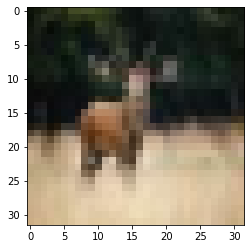

In [19]:
# choice = np.random.randint(len(cifar_images_gray))
choice = 6144
query = cifar_images_gray[choice]
print(choice)
plt.imshow(cifar_images[choice])

In [20]:
%%time
nn, dist, vn = search_pruning_vn(tree, query)
print(vn)

3
Wall time: 17 s


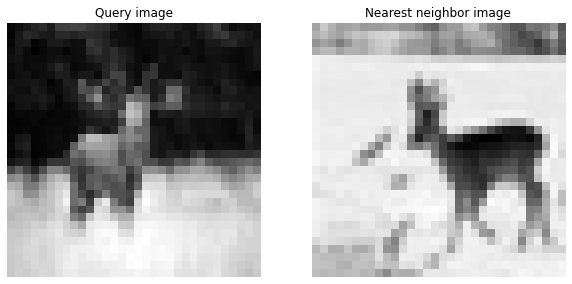

In [21]:
plot_compare(query, nn)

1064


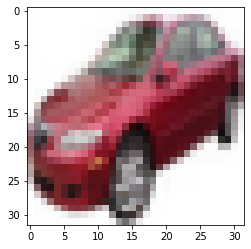

In [15]:
choice = 1064
query = cifar_images_gray[choice]
print(choice)
plt.imshow(cifar_images[choice])

In [16]:
%%time
nn, dist, vn = search_pruning_vn(tree, query)
print(vn)

4
Wall time: 23.1 s


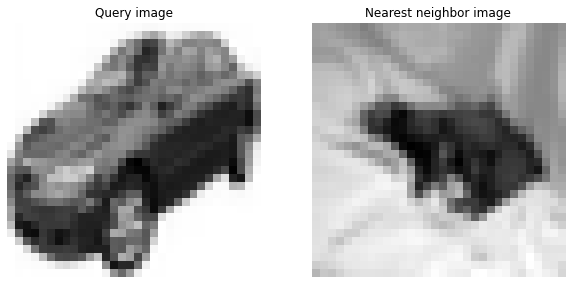

In [17]:
plot_compare(query, nn)